# Linear Regression in probabilistic modelling

Linear regression is one of the simplest yet mostly used regression techniquess that uses a set of independet variables $x_1, x_2, \ldots$ to predict a dependent variable $y$.
In linear regression, we assume that all independent variables $x_i$ are independent from each other and that only linear relationships exist in the data. While in realistic scenarios, these assumptios are rarely fulfilled, linear regression can often be used as a base-line when developing more complex models.

In this example we show how probabilistic modelling can be used to estimate the posterior of a linear regression model and determine a point estimator such as the most probable value with an estimate of the uncertainty.

Based on: https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html#glm-linear



In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import pymc as pm

from pymc import HalfCauchy, Model, Normal, sample

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.18.0


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-colors")

In normal linear regression we define a linear model like this:

$$ y = \sum_i \alpha_i x_i + \beta$$

meaning that the values $y$ of our dependent variable $Y$ is given by a linear sum 
where each independent variable $X_i$ (with value $x_i$) is modified with some coefficient $\alpha_i$
plus a constant. In the simplest case, our model is given by a straight line $y= \alpha \cdot x +\beta$,
or, in the more familiar notation $y=m \cdot x + b$.

Typically, we have a dataset containing both the dependendent variable $Y$ and the independent
variable(s) $X$ and use linear regression to find the best description of the dataset.

## Generate artificial data
Define a small function which generates test data according to a linear model in the following way:
* $x$-axis: Random numbers drawn from a Gaussian (Normal) distribution with default parameters ($\mu=0$, $\sigma = 1$)
* $y$-axis: $x$-value times slope plus a noise term (Gaussian random numbers)
   
For simplicty we use one one independent variable and set the intercept, i.e. the constant term, to zero.


The input parameters to this function are: 
* The number of samples to generate
* The true slope of the linear model
* The level of noise to be simulated

The function returns two arrays for the $x$ and $y$ values, respectively.


In [3]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame({"x": x, "y": y})

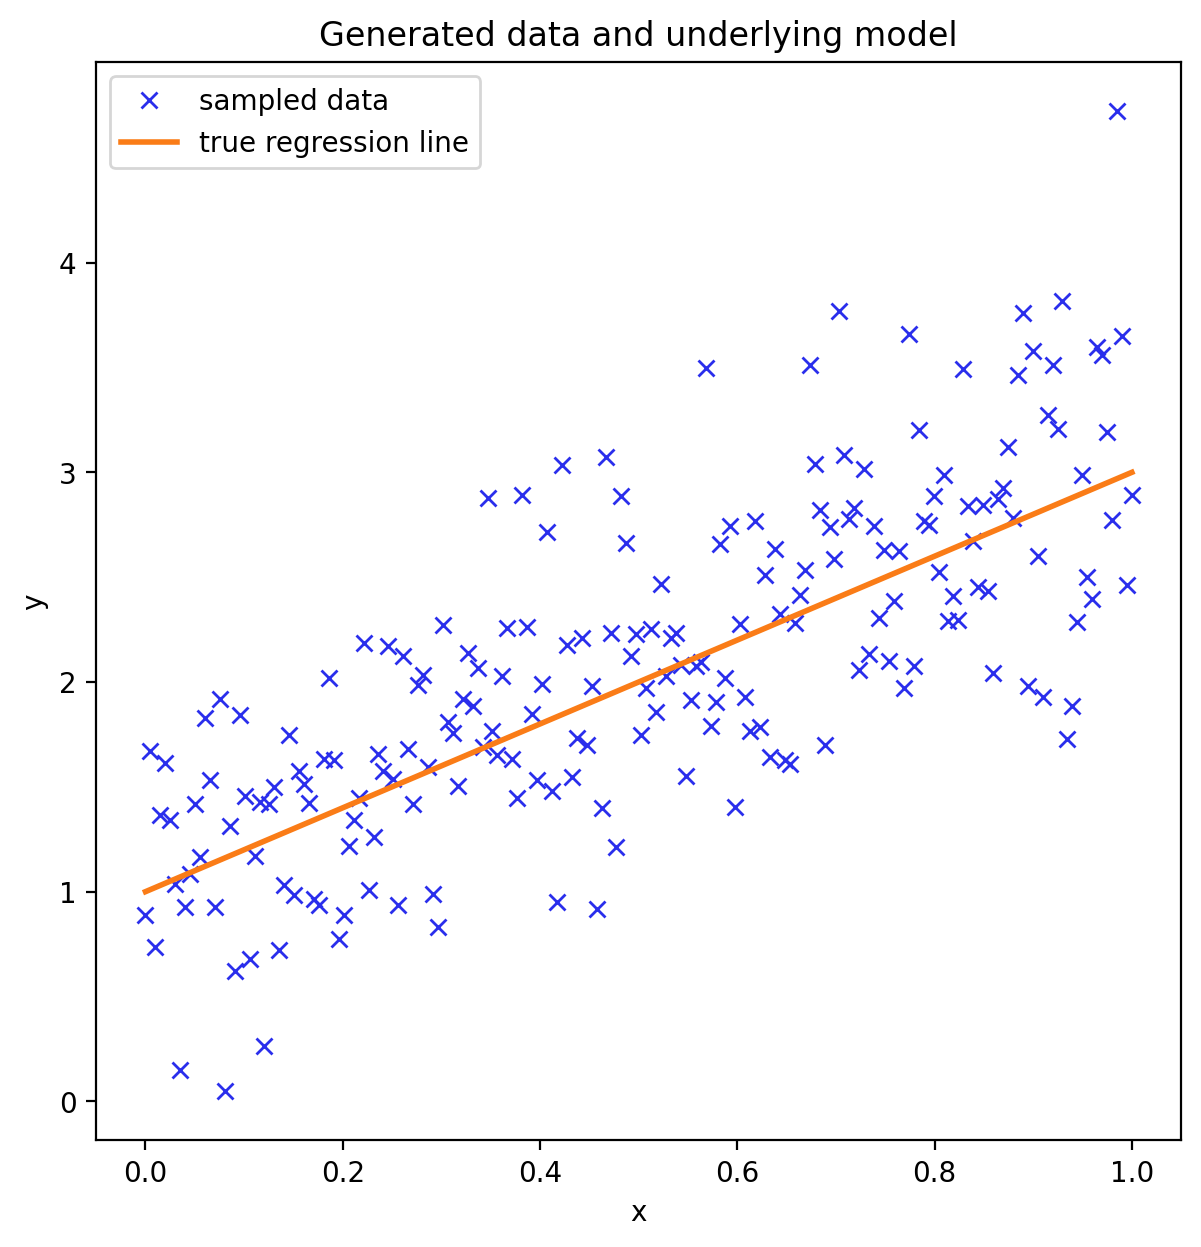

In [4]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

In standard linear regression we would now fit a linear model, in our case a straight line:

Now we interpret this differently - from a probabilisitic point of view.
What we said above is that our independent variable $Y$  is essentially a random variable (because the independent variable $X$ is a random variable) that has a linear relationship with with some noise. In our model above
we assumed that the noise follows a Gaussian or normal distribution.
Hence our linear regression model means that $Y$ follows a Gaussian distribution where the mean is given by a constant times the independent variable $X$ with some variance $\sigma^2$. We also allow an
intercept $b$.

We can express this mathematically as:

$$Y \sim {\cal N}(\beta X +b, \sigma^2) $$

Hence our probabilistic model also has two free parameter, the coefficient
 $\beta$ (i.e. the slope in a simple linear regression) and constant $b$
 (the intercept in a simple linear regression)

Since we focus on Bayesian probabilistic modelling,
we need to assign a prior to the variables in our model, in our
case the constant $\sigma^2$.
The conjugate prior for the linear regression model for the variance
is an inverse Gamma distribution (see [Wikipedia](https://en.wikipedia.org/wiki/Bayesian_linear_regression#Conjugate_prior_distribution)). However, it
is recommended by [Polson](https://projecteuclid.org/euclid.ba/1354024466)
and [Gelman](https://projecteuclid.org/euclid.ba/1340371048) to use a wide half-Cauchy distribution as a non-informative or weakly informative prior.
For the constant we choose a wide Gaussian distribution.


In [10]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy("sigma", beta=10)
    intercept = Normal("Intercept", 0, sigma=20)
    slope = Normal("slope", 0, sigma=20)

    # Define model
    likelihood = Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


C:\Users\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 37 seconds.


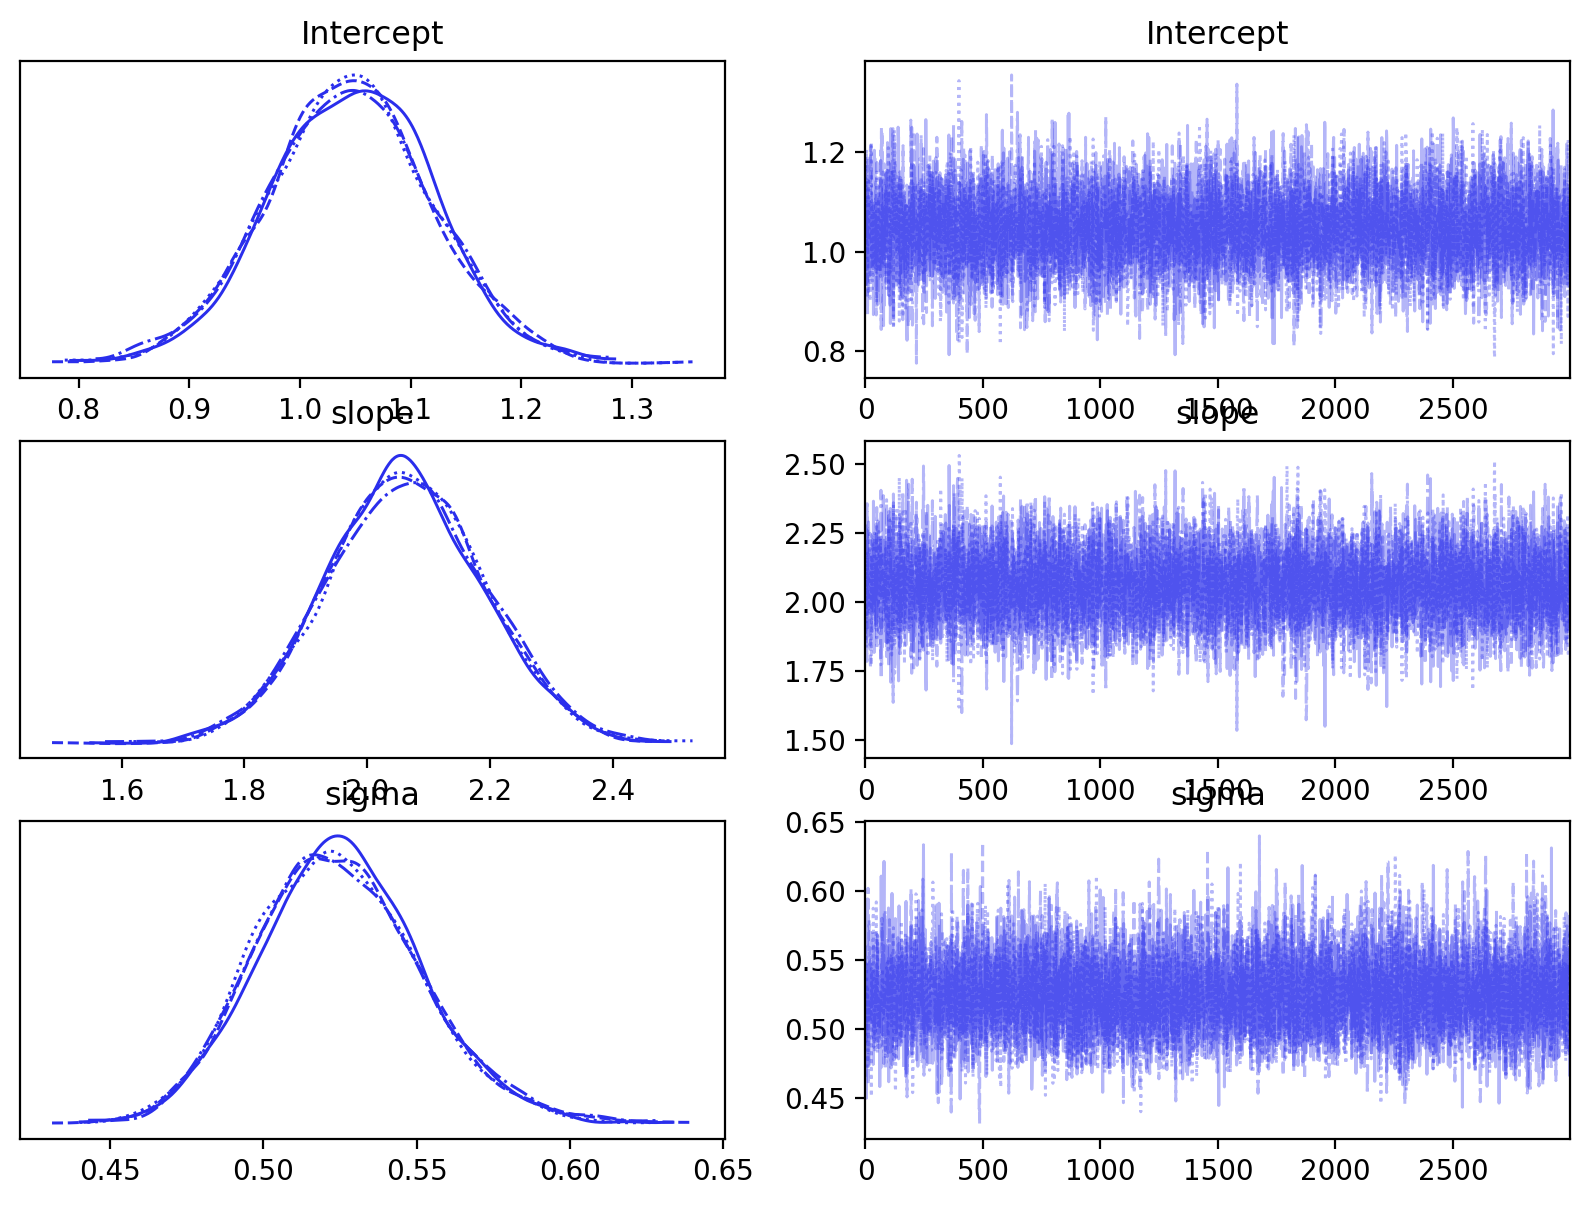

In [11]:
az.plot_trace(idata, figsize=(10, 7));

In [13]:
idata.posterior["y_model"] = idata.posterior["Intercept"] + idata.posterior["slope"] * xr.DataArray(x)

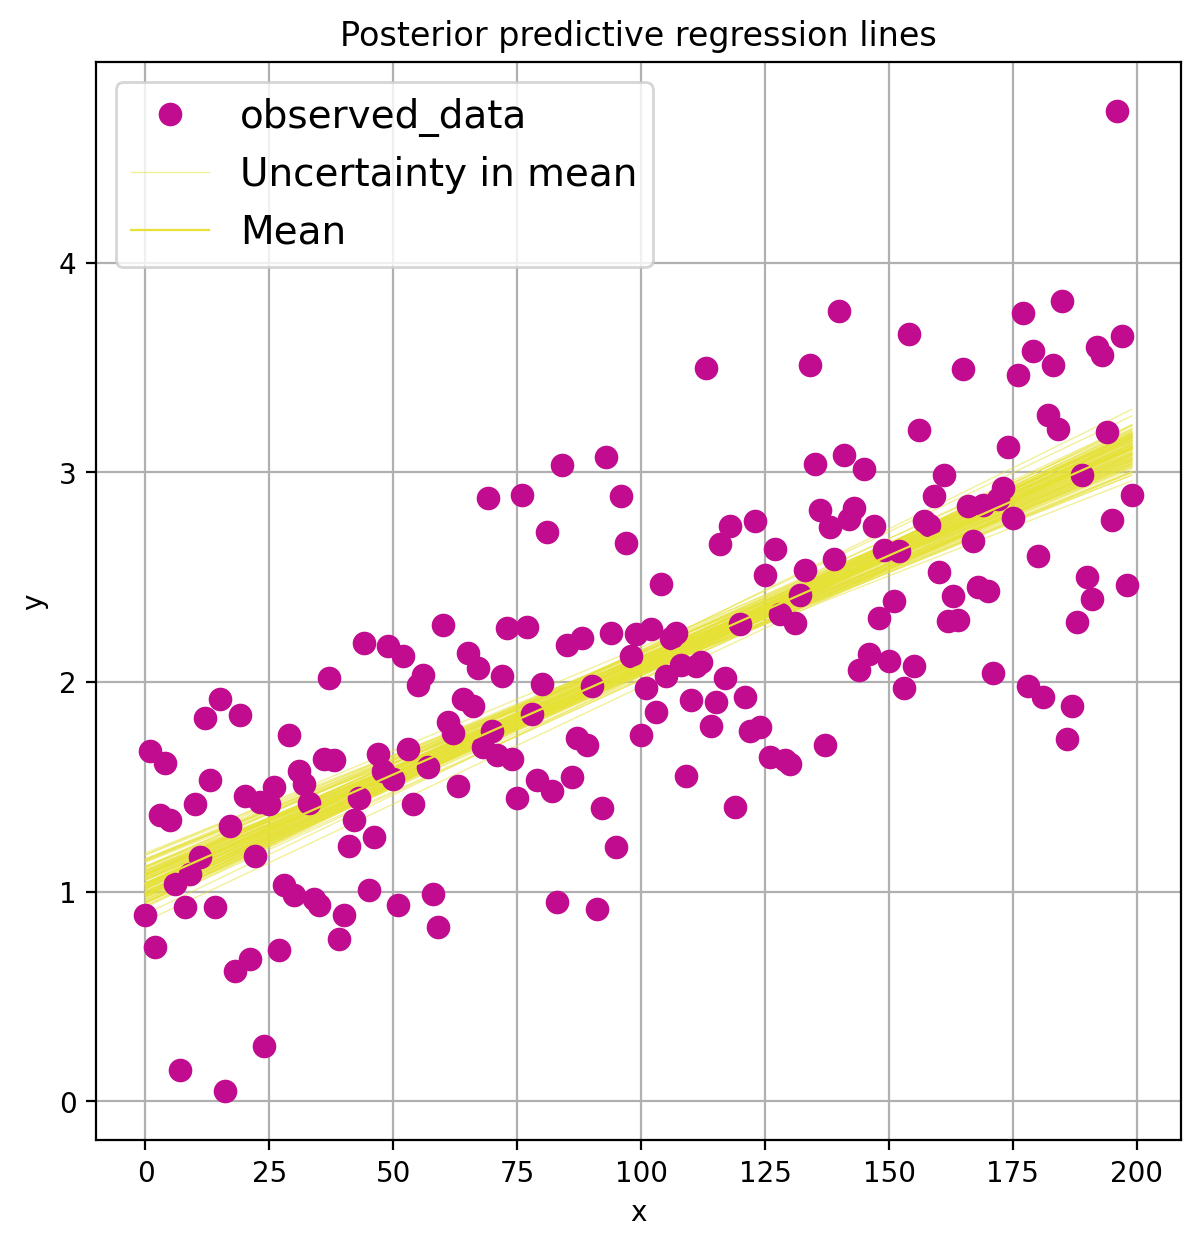

In [14]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=idata, y="y", num_samples=100, axes=ax, y_model="y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x");
lines = ax.get_lines()
plt.show()

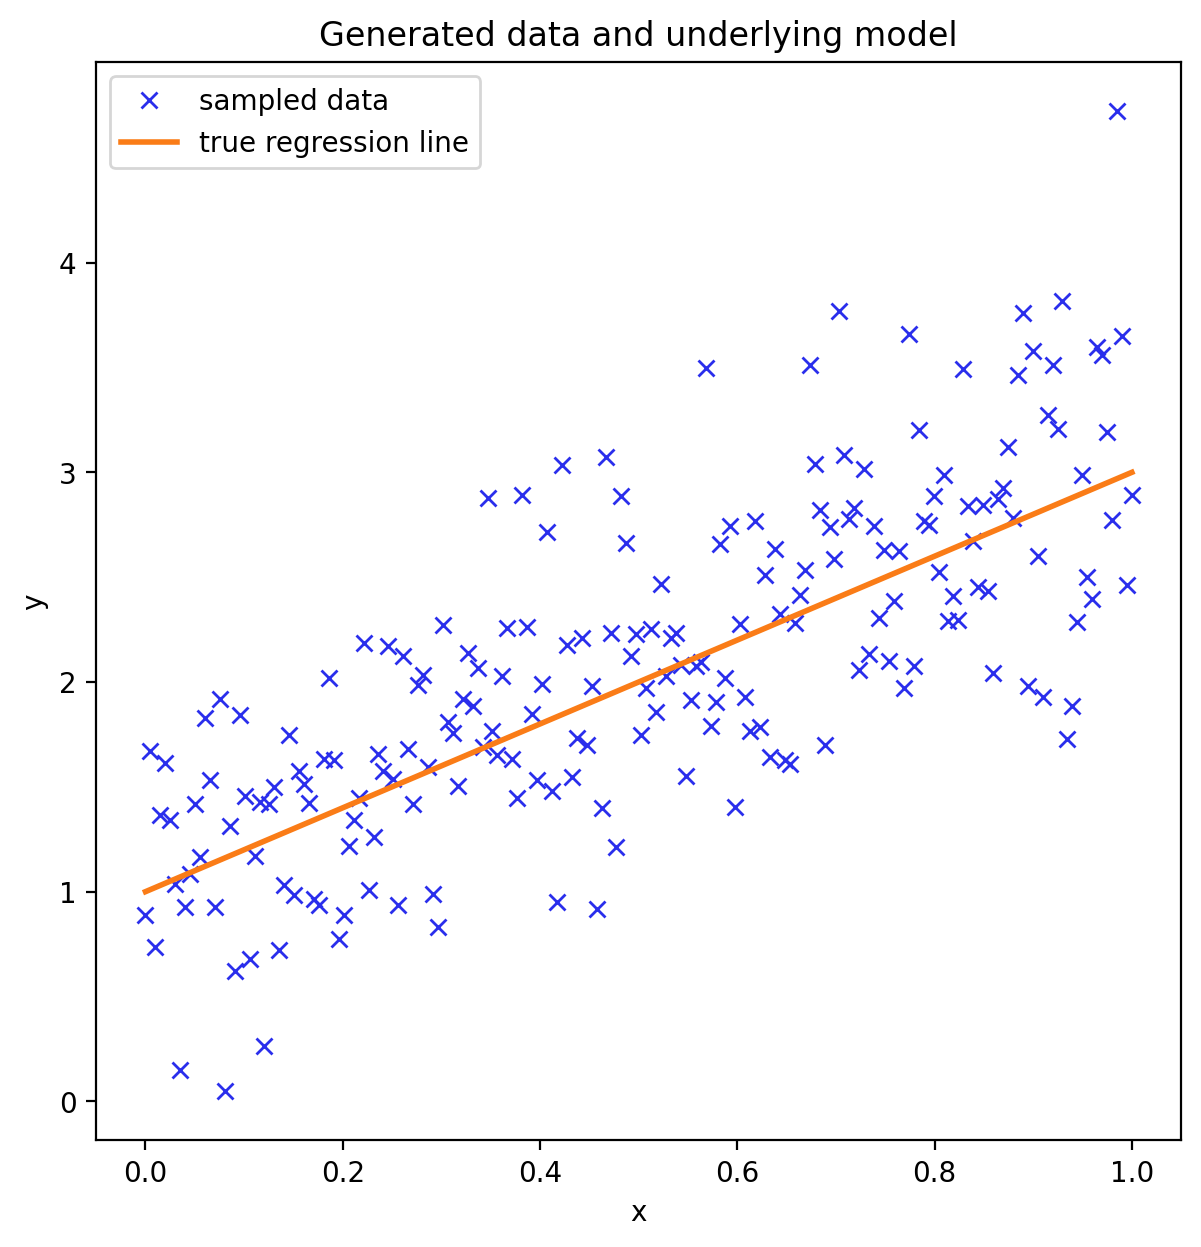

In [9]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);